# Проверка нового алгоритма рекомендаций

## Постановка задачи

Одна из важных бизнес-задач для руководства компании - увеличение времени пользования приложением. Один из путей решения этой задачи - повышение интереса к публикуемым постам. Команда ML сделала новый алгоритм рекомендаций новостей в ленте.  

Задача проведения A/B  теста - проверка гипотезы о том, что новый алгоритм повысит интерес к ленте новостей.

## Выбор подходящих метрик

Интерес пользователя выражается реакцией "like" на просмотренный пост.
Увеличение CTR из просмотров в лайки будет говорить, что посты действительно стали интереснее.

- Нулевая гипотеза: CTR в двух группах на самом деле не отличаются и наблюдаемые различия случайны.
- Альтернативная гипотеза: CTR в двух группах статистически значимо отличаются.

## Дизайн эксперимента

### Проверка системы сплитования

Для проверки того, что группы, на которые мы побили пользователей, не отличаются друг от друга до тех пор, пока мы не выкатили на них новую функциональность с 21.06.2024 по 27.06.2024 проводится А/А-тест.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np

In [ ]:
feed_groups_aa = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/feed_groups_aa.csv')

In [ ]:
feed_aa_group_2 = feed_groups_aa[feed_groups_aa['exp_group'] == 2] #данные о пользователях из группы 2

In [ ]:
feed_aa_group_3 = feed_groups_aa[feed_groups_aa['exp_group'] == 3] #данные о пользователях из группы 3

#### Проверка данных в группах

In [ ]:
feed_groups_aa.info() #проверка на пропуски в данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16787 entries, 0 to 16786
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  16787 non-null  int64  
 1   exp_group   16787 non-null  int64  
 2   user_id     16787 non-null  int64  
 3   likes       16787 non-null  int64  
 4   views       16787 non-null  int64  
 5   ctr         16787 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 787.0 KB


In [ ]:
feed_groups_aa.user_id.nunique() # проверка на повторы id пользователей

16787

In [ ]:
feed_aa_group_2.user_id.nunique() / feed_groups_aa.user_id.nunique() # доля пользователей из группы 2

0.4981235479835587

#### Анализ результатов А-А теста

In [ ]:
pvalue = pd.Series() # пустая серия для записи значений p-value
for i in range(10000):
    sample_group_2 = feed_aa_group_2.sample(n=500, replace=False) #создание подвыборки без повторения в 500 юзеров из группы 2
    sample_group_3 = feed_aa_group_3.sample(n=500, replace=False) #создание подвыборки без повторения в 500 юзеров из группы 3
    results = st.ttest_ind(sample_group_2.ctr,
                sample_group_3.ctr,
                equal_var=False) #сравнение подвыборок t-testом
    pvalue[i] = results.pvalue #запись значений p-value

In [ ]:
feed_aa_p_values = pd.DataFrame(pvalue).rename(columns={0:"pvalue"})

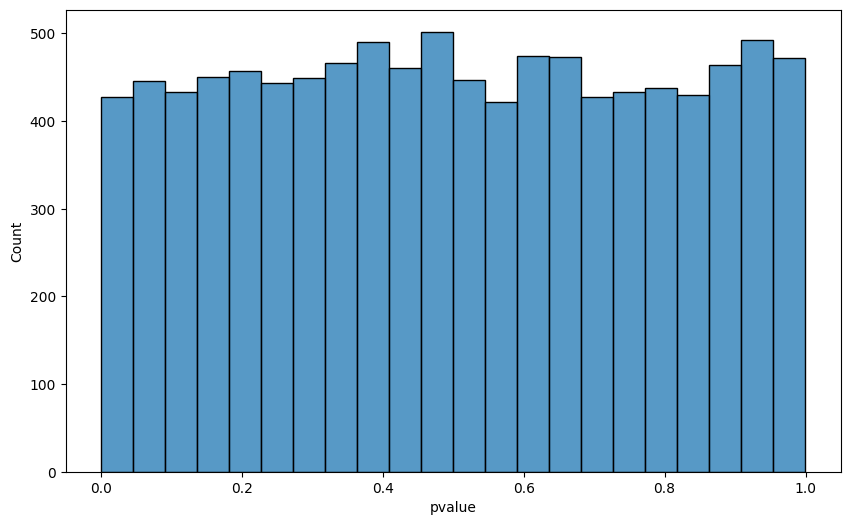

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
# sns.displot(data=feed_aa_p_values, x="pvalue")
groups = sns.histplot(data = feed_aa_p_values,
              x='pvalue',
              kde=False)#гистограмма распределения получившихся 10000 p-values

In [ ]:
feed_aa_p_values.query('pvalue <= 0.05').count().iloc[0] / 100 #процент значений p-values меньше либо равных 0.05

4.59

#### Вывод

Статистически значимые различия между группой 2 и группой 3 получились в 4,59% случаев, что не превышает уровень значимости в 5%. Система сплитования работает корректно.

## Сбор данных

Даты проведения A/B  теста: с '2024-06-28' по '2024-07-04'

  * Группа 2 - тест
  * Группа 1 - контроль

## Эксплораторный анализ и предобработка

In [2]:
feed_groups_ab_2_1 = pd.read_csv('/content/drive/MyDrive/feed_groups_ab_2_1.csv')

In [3]:
feed_ab_group_test = feed_groups_ab_2_1[feed_groups_ab_2_1['exp_group'] == 2] #данные о пользователях из тестовой группы (группа 2)

In [4]:
feed_ab_group_control = feed_groups_ab_2_1[feed_groups_ab_2_1['exp_group'] == 1] #данные о пользователях из контрольной группы (группа 1)

### Проверка данных в группах

In [5]:
feed_groups_ab_2_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  19897 non-null  int64  
 1   exp_group   19897 non-null  int64  
 2   user_id     19897 non-null  int64  
 3   likes       19897 non-null  int64  
 4   views       19897 non-null  int64  
 5   ctr         19897 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 932.8 KB


In [6]:
feed_groups_ab_2_1.user_id.nunique() # проверка на повторы id пользователей

19897

In [7]:
feed_ab_group_test.user_id.nunique() / feed_groups_ab_2_1.user_id.nunique() # доля пользователей из группы 2

0.4964064934412223

### Визуальный анализ распределений CTR в группах

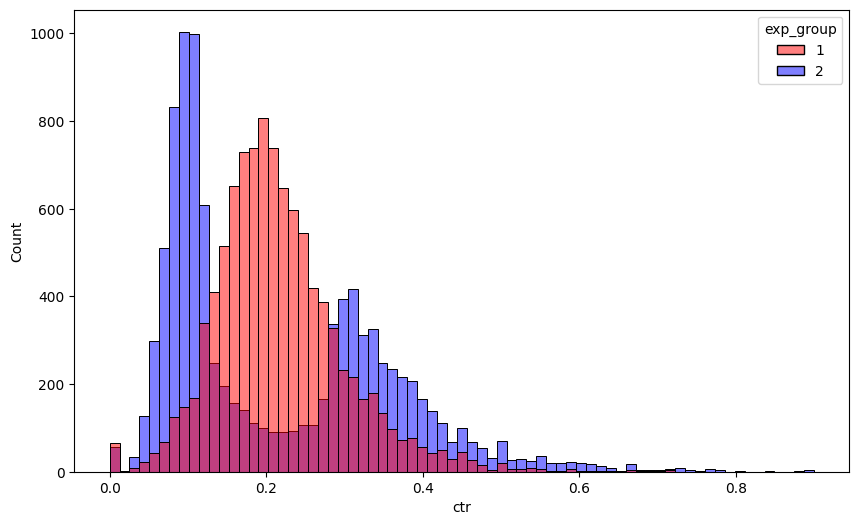

In [13]:
f, ax = plt.subplots(figsize=(10, 6))
groups = sns.histplot(data = feed_groups_ab_2_1,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False) #гистограммы распределений СTR в группах (1-контроль, 2-тест)

Бимодальное распределение значений CTR в тестовой группе может говорить о том, что новый алгоритм рекомендаций "поделил" пользователей на две группы:
    
  1. пользователи, которым новые рекомендации скорее не подошли (мода смещена влево от тестовой группы). Возможно эти пользователи не любят смотреть посты про одно и то же.
  2. пользователи, которым новые рекомендации чаще нравились (мода смещена вправо от тестовой группы). Любители посмотреть кучу постов про одно и то же.
    
При этом пик числа пользователей с болеее низким CTR выше, чем пользователей с болеее высоким CTR. Что может говорить о том, что новый алгоритм скорее не приводит к поставленной цели - повышению CTR.

## Статистический вывод

Форма распределения CTR в тестовой группе не близка к нормальной и отличается от контрольной группы.
   
Для подсчета разницы в CTR в двух группах применим Пуассоновский бутстрап.


H0 - общегрупповые CTR в группах 2 и 1 не различаются

H1 - есть различия в общегрупповых CTR в группах 2 и 1

<Axes: ylabel='Count'>

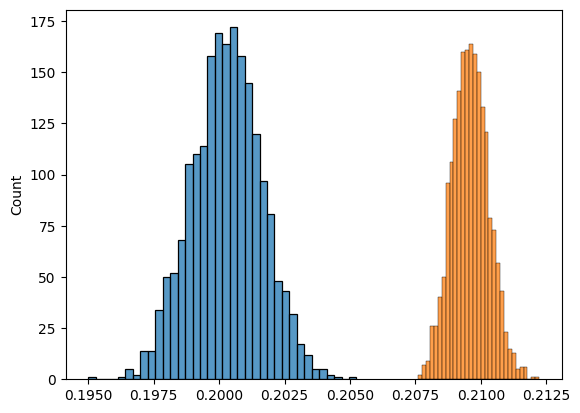

In [11]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)


    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = feed_ab_group_test.likes.to_numpy()
views1 = feed_ab_group_test.views.to_numpy()
likes2 = feed_ab_group_control.likes.to_numpy()
views2 = feed_ab_group_control.views.to_numpy()

ctr_test, ctr_control = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr_test)
sns.histplot(ctr_control)

<Axes: ylabel='Count'>

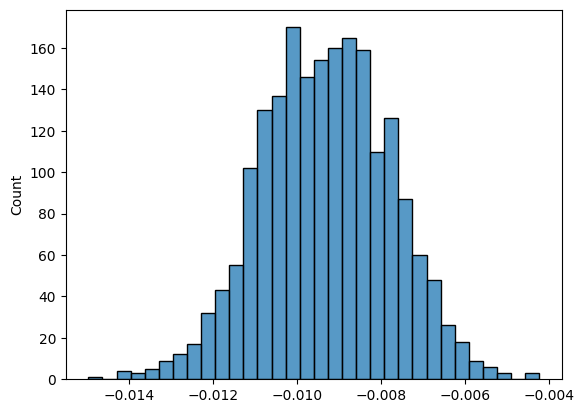

In [12]:
sns.histplot(ctr_test - ctr_control) #Разница между глобальными CTR

# Вывод

По результатам статистической оценки различий в общегрупповом CTR, новый алгоритм рекомендаций приводит к снижению CTR на 0,4-1,4%. Что говорит о том, что раскатывать новый алгоритм на всех новых пользователей не стоит.